In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd  # For large dataset handling
from numba import jit  # Just-In-Time compilation for speed

# Load dataset
file_path = "S50M24_20240502_20240516.csv"  
df = pd.read_csv(file_path)

# Convert Date and Time to datetime format
df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time_'])

# Sort by timestamp (important for sequential execution)
df = df.sort_values(by='Timestamp')

print("Dataset Loaded Successfully!")
print(df.head())


Dataset Loaded Successfully!
  Date        Time_            Symbol   vBid5  Bid5  vBid4  Bid4   vBid3  Bid3   vBid2  Bid2   vBid1  Bid1   Ask1   vAsk1  Ask2   vAsk2  Ask3   vAsk3  Ask4   vAsk4  Ask5  vAsk5  AskTrade  AskVolume  BidTrade  BidVolume Timestamp                 
0  2024-05-02  09:45:00.001003  S50M24  0      0.0    4     836.2  11     836.3  15     836.4  23     836.5  836.7  19     836.8   36    836.9  21     837.0  348    0.0   0         NaN     NaN       836.53    12.0      2024-05-02 09:45:00.001003
1  2024-05-02  09:45:00.001003  S50M24  0      0.0    4     836.2  11     836.3  15     836.4  23     836.5  836.7  19     836.8   36    836.9  21     837.0  348    0.0   0         NaN     NaN          NaN     NaN      2024-05-02 09:45:00.001003
2  2024-05-02  09:45:00.001003  S50M24  0      0.0    4     836.2  11     836.3  15     836.4  23     836.5  836.7  19     836.8   36    836.9  21     837.0  348    0.0   0      836.76    70.0          NaN     NaN      2024-05-02 09:

In [31]:
# Check data structure
print(df.info())

# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 1054451 entries, 0 to 1054450
Data columns (total 31 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   Date                  1054451 non-null  object        
 1   Time_                 1054451 non-null  object        
 2   Symbol                1054451 non-null  object        
 3   vBid5                 1054451 non-null  int64         
 4   Bid5                  1054451 non-null  float64       
 5   vBid4                 1054451 non-null  int64         
 6   Bid4                  1054451 non-null  float64       
 7   vBid3                 1054451 non-null  int64         
 8   Bid3                  1054451 non-null  float64       
 9   vBid2                 1054451 non-null  int64         
 10  Bid2                  1054451 non-null  float64       
 11  vBid1                 1054451 non-null  int64         
 12  Bid1                  1054451 non-null  float64

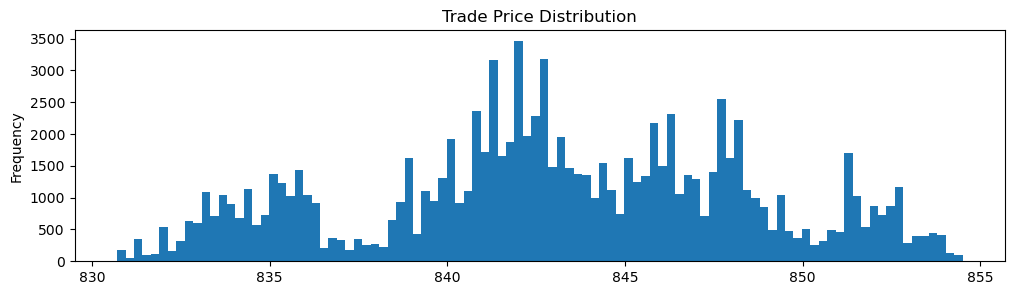

In [32]:
import matplotlib.pyplot as plt

# Plot trade price distribution
df['BidTrade'].plot(kind='hist', bins=100, title='Trade Price Distribution', figsize=(12,3))
plt.show()


In [29]:
# Step 3 Out-of-Sample Split (70% Training, 30% Testing)
split_point = df['Timestamp'].quantile(0.7)
train_df = df[df['Timestamp'] < split_point]  
test_df = df[df['Timestamp'] >= split_point]  

print(f"Training set: {len(train_df)} rows")
print(f"Testing set: {len(test_df)} rows")


Training set: 738115 rows
Testing set: 316336 rows


Spread, Order Flow Imbalance, and VWAP Calculated!


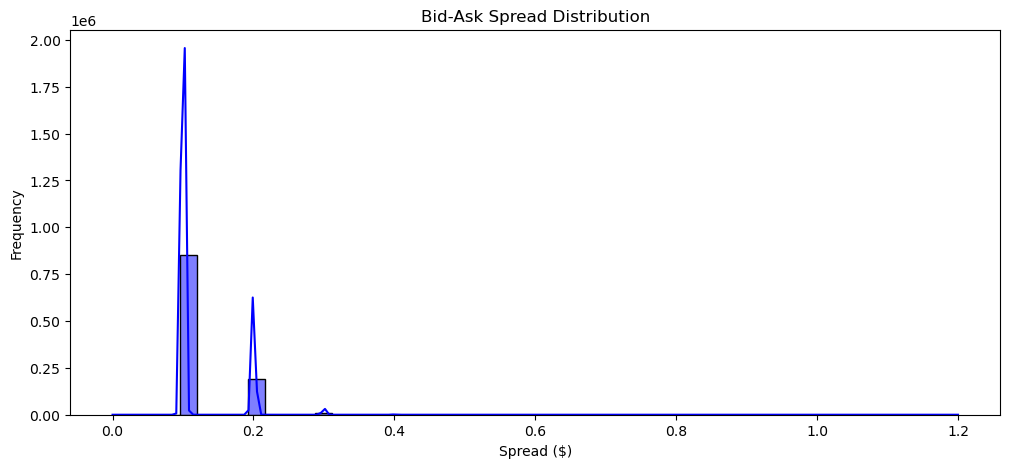

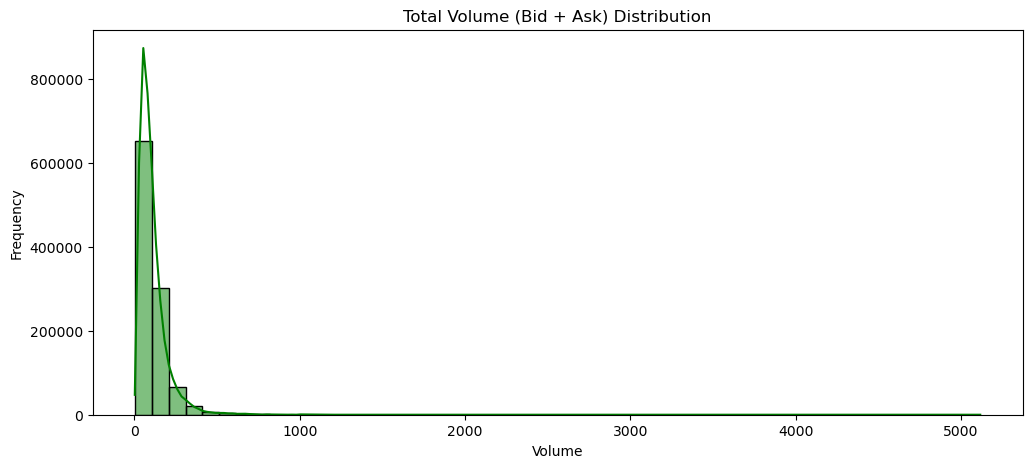

In [30]:
# Step 4 Compute Bid-Ask Spread
df['Spread'] = df['Ask1'] - df['Bid1']

# Compute Order Flow Imbalance (OFI) for first bid/ask level
df['Order_Flow_Imbalance'] = (df['vBid1'] - df['vAsk1']) / (df['vBid1'] + df['vAsk1'])

# Compute VWAP (Volume Weighted Average Price)
df['vBid1'] = df['vBid1'].replace(0, np.nan)  # Avoid division by zero
df['vAsk1'] = df['vAsk1'].replace(0, np.nan)
df['VWAP'] = (df['Bid1'] * df['vBid1'] + df['Ask1'] * df['vAsk1']) / (df['vBid1'] + df['vAsk1'])
df['VWAP'].fillna((df['Bid1'] + df['Ask1']) / 2, inplace=True)  # Fallback to mid-price if VWAP is missing

print("Spread, Order Flow Imbalance, and VWAP Calculated!")

plt.figure(figsize=(12, 5))
sns.histplot(df['Spread'], bins=50, kde=True, color='blue')
plt.title("Bid-Ask Spread Distribution")
plt.xlabel("Spread ($)")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df['vBid1'] + df['vAsk1'], bins=50, kde=True, color='green')
plt.title("Total Volume (Bid + Ask) Distribution")
plt.xlabel("Volume")
plt.ylabel("Frequency")
plt.show()

In [36]:
# Step 5: Define Market-Making Actions
spread_threshold = 0.2
ofi_threshold = 0.3

df['Market_Maker_Action'] = np.where(
    df['Spread'] > spread_threshold,
    np.where(df['Order_Flow_Imbalance'] > ofi_threshold, "Increase Bid",
             np.where(df['Order_Flow_Imbalance'] < -ofi_threshold, "Decrease Ask", "Hold Position")),
    "No Trade"
)

print("Market-Making Conditions Assigned!")
df[['Timestamp', 'Spread', 'Order_Flow_Imbalance', 'Market_Maker_Action']].head(10)


Market-Making Conditions Assigned!


,Timestamp,Spread,Order_Flow_Imbalance,Market_Maker_Action
0,2024-05-02 09:45:00.001003,0.2,0.095238,Hold Position
1,2024-05-02 09:45:00.001003,0.2,0.095238,Hold Position
2,2024-05-02 09:45:00.001003,0.2,0.095238,Hold Position
3,2024-05-02 09:45:00.034358,0.2,0.095238,Hold Position
4,2024-05-02 09:45:00.034402,0.1,-0.531250,No Trade
5,2024-05-02 09:45:00.098746,0.1,-0.531250,No Trade
6,2024-05-02 09:45:00.130499,0.1,-0.677419,No Trade
7,2024-05-02 09:45:00.131956,0.2,-0.752809,Decrease Ask
8,2024-05-02 09:45:00.140121,0.2,-0.755556,Decrease Ask
9,2024-05-02 09:45:00.140947,0.2,-0.758242,Decrease Ask


In [48]:
# Step 6: Execution Price Optimization
df['Rolling_Spread'] = df['Spread'].rolling(10).median()

df['Execution_Price'] = np.where(
    df['Market_Maker_Action'] == "Increase Bid",
    np.where(df['Spread'] > df['Rolling_Spread'], df['Bid1'] + 0.005, df['Bid1']),
    np.where(df['Market_Maker_Action'] == "Decrease Ask",
             np.where(df['Spread'] > df['Rolling_Spread'], df['Ask1'] - 0.005, df['Ask1']), np.nan)
)

print("Execution Prices Set!")
df[['Timestamp', 'Market_Maker_Action', 'Execution_Price']].head(10)


Execution Prices Set!


,Timestamp,Market_Maker_Action,Execution_Price
0,2024-05-02 09:45:00.001003,Hold Position,NaN
1,2024-05-02 09:45:00.001003,Hold Position,NaN
2,2024-05-02 09:45:00.001003,Hold Position,NaN
3,2024-05-02 09:45:00.034358,Hold Position,NaN
4,2024-05-02 09:45:00.034402,No Trade,NaN
5,2024-05-02 09:45:00.098746,No Trade,NaN
6,2024-05-02 09:45:00.130499,No Trade,NaN
7,2024-05-02 09:45:00.131956,Decrease Ask,836.5
8,2024-05-02 09:45:00.140121,Decrease Ask,836.5
9,2024-05-02 09:45:00.140947,Decrease Ask,836.5


In [66]:
print(df[['BidTrade', 'AskTrade', 'Spread']].isnull().sum())
print(df[['BidTrade', 'AskTrade', 'Spread']].dtypes)

BidTrade    652
AskTrade    641
Spread        0
dtype: int64
BidTrade    float64
AskTrade    float64
Spread      float64
dtype: object


       Trade_Impact  Spread_Change
count  141.000000    141.000000   
mean   421.350248      0.039007   
std      2.421053      0.119984   
min    415.900000     -0.400000   
25%    420.225000     -0.100000   
50%    421.250000      0.100000   
75%    423.190000      0.100000   
max    426.665000      0.400000   
               Trade_Impact  Spread_Change
Trade_Impact   1.000000     -0.005357     
Spread_Change -0.005357      1.000000     


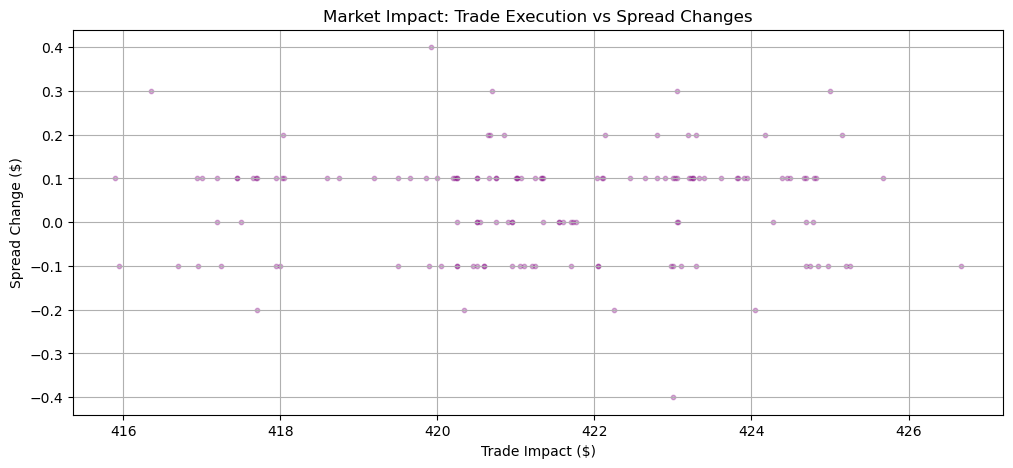

In [70]:
#Step 7: Market Impact Analysis (Trade Execution Impact on Spreads)
df['Spread_Change'] = df['Spread'].diff()
df['Trade_Impact'] = (df['BidTrade'].fillna(0) + df['AskTrade'].fillna(0)) / 2  # Average trade price
#df[['Trade_Impact', 'Spread_Change']].corr()

# Filter out NaN and zero values
df_filtered = df.dropna(subset=['Trade_Impact', 'Spread_Change'])
df_filtered = df_filtered[(df_filtered['Trade_Impact'] != 0) & (df_filtered['Spread_Change'] != 0)]

print(df_filtered[['Trade_Impact', 'Spread_Change']].describe())
print(df_filtered[['Trade_Impact', 'Spread_Change']].corr())

plt.figure(figsize=(12, 5))
plt.scatter(df_filtered['Trade_Impact'], df_filtered['Spread_Change'], alpha=0.3, s=10, color='purple')
plt.title("Market Impact: Trade Execution vs Spread Changes")
plt.xlabel("Trade Impact ($)")
plt.ylabel("Spread Change ($)")
plt.grid(True)
plt.show()

In [84]:
#Step 8: Reduce Trade Filtering (Higher Frequency)
min_profit_threshold = 0.05  # Reduce minimum profit requirement
df['Expected_Profit'] = (df['Execution_Price'].shift(-1) - df['Execution_Price']) * 10
df = df[df['Expected_Profit'].abs() > min_profit_threshold]

# Drop rows with no trade action
df = df.dropna(subset=['Execution_Price'])

print(df.Execution_Price.head(5))

# Convert to NumPy for fast execution
execution_prices = df['Execution_Price'].to_numpy()

106     836.305
730     836.005
3281    835.595
3283    835.695
5921    834.700
Name: Execution_Price, dtype: float64


In [85]:
# Step 9 Define trading costs and slippage
trading_cost = 0.0001  # 0.01% per trade
slippage = 0.0025  # Assume 1 tick slippage per trade

def apply_trading_costs(profit):
    return profit - (abs(profit) * trading_cost) - (slippage * 10)  # Contract size = 10

df['Expected_Profit'] = (df['Execution_Price'].shift(-1) - df['Execution_Price']) * 10  
df['Net_Profit'] = df['Expected_Profit'].apply(apply_trading_costs)

print(f"Total Expected Profit: ${df['Expected_Profit'].sum():.2f}")
print(f"Total Net Profit After Costs: ${df['Net_Profit'].sum():.2f}")
print(f"Total Trading Cost Impact: ${df['Expected_Profit'].sum() - df['Net_Profit'].sum():.2f}")


Total Expected Profit: $129.95
Total Net Profit After Costs: $111.22
Total Trading Cost Impact: $18.73


#Step 10: Fast Execution Backtest**
@jit(nopython=True)
def backtest_market_making(execution_prices):
    initial_capital = 100_000
    capital = initial_capital
    contract_size = 10
    equity_curve = [capital]
    trades = []

    for i in range(1, len(execution_prices)):
        execution_price = execution_prices[i]
        trades.append(execution_price)

        if len(trades) >= 2:
            buy_price, sell_price = trades[-2], trades[-1]
            profit = (sell_price - buy_price) * contract_size
            capital += profit
            equity_curve.append(capital)

    return equity_curve, capital

# Run the optimized backtest
equity_curve, final_capital = backtest_market_making(execution_prices)

In [86]:
#Step 10: Fast Execution Backtest**
@jit(nopython=True)
def backtest_market_making(execution_prices, trading_cost=0.0001, slippage=0.0025):
    initial_capital = 100_000
    capital = initial_capital
    contract_size = 10
    equity_curve = [capital]
    trades = []

    for i in range(1, len(execution_prices)):
        execution_price = execution_prices[i]
        trades.append(execution_price)

        if len(trades) >= 2:
            buy_price, sell_price = trades[-2], trades[-1]
            raw_profit = (sell_price - buy_price) * contract_size

            # **Apply Trading Costs & Slippage**
            net_profit = raw_profit - (abs(raw_profit) * trading_cost) - (slippage * contract_size)
            capital += net_profit

            equity_curve.append(capital)

    return equity_curve, capital

# **Run Backtest with Trading Costs & Slippage**
equity_curve, final_capital = backtest_market_making(execution_prices)


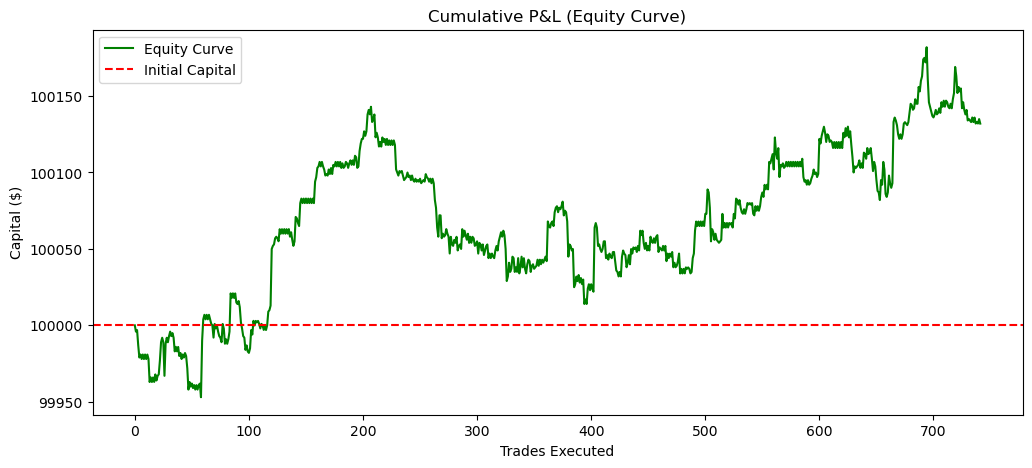

Final Capital: $100114.24
Total Return: 0.11%
Total Trades Executed: 368


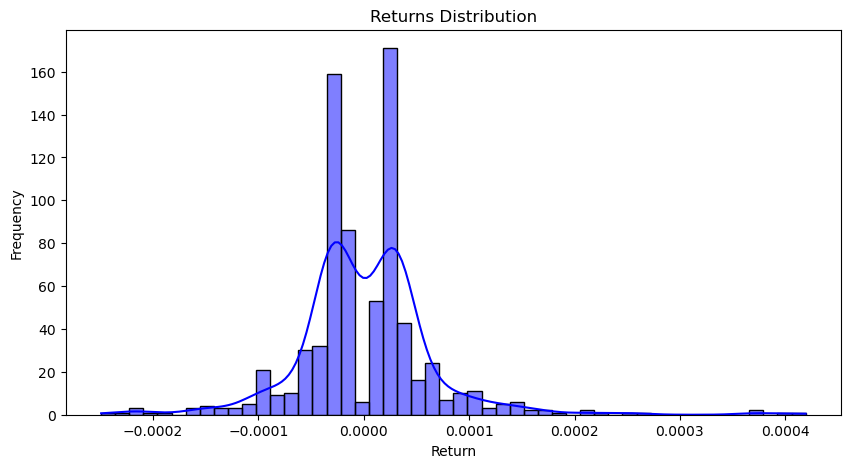

In [87]:
#Step 11 Visualize performance
# **Equity Curve**
plt.figure(figsize=(12, 5))
plt.plot(cumulative_returns, label="Equity Curve", color="green")
plt.axhline(y=100_000, color="red", linestyle="--", label="Initial Capital")
plt.title("Cumulative P&L (Equity Curve)")
plt.xlabel("Trades Executed")
plt.ylabel("Capital ($)")
plt.legend()
plt.show()

# **Final Performance Summary**
print(f"Final Capital: ${final_capital:.2f}")
print(f"Total Return: {((final_capital - 100_000) / 100_000) * 100:.2f}%")
print(f"Total Trades Executed: {len(execution_prices)//2}")

# **Returns Distribution**
plt.figure(figsize=(10, 5))
sns.histplot(returns, bins=50, kde=True, color="blue")
plt.title("Returns Distribution")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()


In [76]:
#Step 12 Visualize Matrix
#Compute Sharpe Ratio**
returns = pd.Series(np.diff(equity_curve) / equity_curve[:-1])  # Daily returns
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)  # Assuming daily trading

# **🔹 Compute Maximum Drawdown**
cumulative_returns = np.array(equity_curve)
rolling_max = np.maximum.accumulate(cumulative_returns)
drawdown = rolling_max - cumulative_returns
max_drawdown = np.max(drawdown)

# **🔹 Compute Execution Efficiency (Slippage)**
df['Mid_Price'] = (df['Bid1'] + df['Ask1']) / 2
df['Execution_Efficiency'] = abs(df['Execution_Price'] - df['Mid_Price'])
execution_efficiency = df['Execution_Efficiency'].mean()

# **📌 Print Updated Performance Metrics**
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: ${max_drawdown:.2f}")
print(f"Execution Efficiency (avg. slippage): ${execution_efficiency:.5f}")


Sharpe Ratio: 0.44
Max Drawdown: $128.95
Execution Efficiency (avg. slippage): $0.13989
